In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras import models,layers,regularizers

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
data_zip = "/content/drive/MyDrive/RetinalSegmentation.zip"
zip_ref = zipfile.ZipFile(data_zip, "r")
zip_ref.extractall("data.zip")
zip_ref.close()

In [4]:
data_zip

'/content/drive/MyDrive/RetinalSegmentation.zip'

In [5]:
retina_dir = '/content/data.zip/retina'
mask_dir = '/content/data.zip/mask'

In [6]:
retina_images = sorted([os.path.join(retina_dir, f) for f in os.listdir(retina_dir) if f.endswith('.png')])
mask_images = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

# First split to separate out the test set (15%)
retina_temp, retina_test, mask_temp, mask_test = train_test_split(retina_images, mask_images, test_size=0.15, random_state=42)

# Second split to separate the remaining data into training (70%) and validation (15%)
retina_train, retina_val, mask_train, mask_val = train_test_split(retina_temp, mask_temp, test_size=0.1765, random_state=42)  # 0.1765 ~ 15% of the original data

print(f'Training set: {len(retina_train)} images')
print(f'Validation set: {len(retina_val)} images')
print(f'Test set: {len(retina_test)} images')


Training set: 733 images
Validation set: 158 images
Test set: 158 images


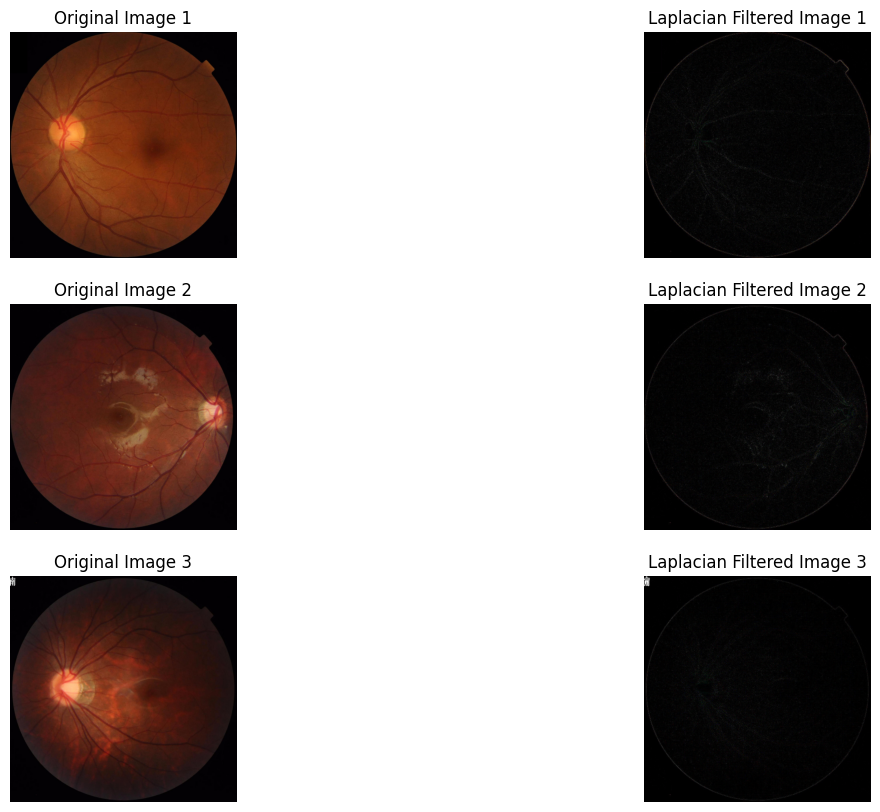

In [7]:
import cv2
import matplotlib.pyplot as plt

# Function to apply Laplacian filter and display images
def show_samples_with_laplacian(images, num_samples=15):
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        sample_image_path = images[i]
        sample_image = cv2.imread(sample_image_path)

        # Apply Laplacian filter
        laplacian_filtered_image = cv2.Laplacian(sample_image, cv2.CV_64F)
        laplacian_filtered_image = cv2.convertScaleAbs(laplacian_filtered_image)

        # Display the original and Laplacian-filtered images side by side
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(laplacian_filtered_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Laplacian Filtered Image {i+1}')
        plt.axis('off')

    plt.show()

# Show samples with Laplacian filter
show_samples_with_laplacian(retina_train, num_samples=3)


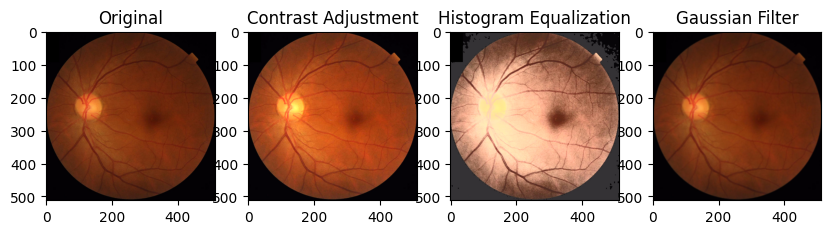

In [8]:
def contrast_adjustment(image):
    alpha = 1.5  # Simple contrast control
    beta = 0    # Simple brightness control
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def histogram_equalization(image):
    if len(image.shape) == 3:
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        equalized = cv2.equalizeHist(image)
    return equalized

def gaussian_filter(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Apply preprocessing techniques

sample_image = cv2.imread(retina_train[0])
contrast_image = contrast_adjustment(sample_image)
equalized_image = histogram_equalization(sample_image)
filtered_image = gaussian_filter(sample_image)

# Display images (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1), plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(1, 4, 2), plt.imshow(cv2.cvtColor(contrast_image, cv2.COLOR_BGR2RGB)), plt.title('Contrast Adjustment')
plt.subplot(1, 4, 3), plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)), plt.title('Histogram Equalization')
plt.subplot(1, 4, 4), plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)), plt.title('Gaussian Filter')
plt.show()

In [16]:
# Function to load and preprocess images using TensorFlow
def load_and_preprocess_image(image_path, mask_path, img_size=(256, 256)):
    # Load and resize retina image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # Load and resize mask image
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to [0, 1]

    return image, mask

# Create TensorFlow datasets for training and validation
def create_dataset(images, masks, batch_size=32, img_size=(256, 256)):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, img_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [17]:
# Create training and validation datasets
batch_size = 8
train_dataset = create_dataset(retina_train, mask_train, batch_size=batch_size)
val_dataset = create_dataset(retina_val, mask_val, batch_size=batch_size)

In [18]:
test_dataset = create_dataset(retina_test, mask_test, batch_size=batch_size)

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [20]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

# Bottleneck

In [21]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''

  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [22]:
def attention_block(gating,x ,inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = tf.keras.layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    #gating = tf.keras.layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
#     upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
#                                  strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
#                                  padding='same')(phi_g)  # 16

    concat_xg = tf.keras.layers.add([phi_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
    #upsample_psi = tf.keras.layers.UpSampling2D(size=(2,2))(sigmoid_xg)

    #upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = tf.keras.layers.multiply([upsample_psi, x])

    result = tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    #result_bn = layers.BatchNormalization()(result)
    return result

In [23]:
# Decoder Utilities

def decoder_block(inputs, conv_output_lowr,conv_output_hgier, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
    c (tensor) -- output features of the decoder block
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    conv_output = attention_block(conv_output_lowr,conv_output_hgier,n_filters)



    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c


def decoder(inputs, convs,encoder_output, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks.

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    '''
    #encoder_output=f5

    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs,encoder_output, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6,f4,f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7,f3,f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8,f2,f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(c9)

    return outputs

In [24]:
OUTPUT_CHANNELS = 1

def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(256, 256,3,))

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    outputs = decoder(bottle_neck, convs,encoder_output, output_channels=OUTPUT_CHANNELS)

    # create the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.004), loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
# number of training images
#train_count =

train_count=len(train_dataset)
# numer of validation images
#validation_count = 101
validation_count=len(val_dataset)
BATCH_SIZE = 64

EPOCHS = 22

#steps_per_epoch = train_count//BATCH_SIZE # BATCH_SIZE = 64
validation_steps = validation_count//BATCH_SIZE

In [27]:
import random
import numpy as np

np.random.seed(44)  # set the random seed to 123

model_history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    #verbose=1,
                    shuffle= True,
                    #steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset
                    #validation_st n ceps=validation_steps
                    )

Epoch 1/22
92/92 [==============================] - 130s 996ms/step - loss: 153510496.0000 - accuracy: 0.8772 - val_loss: 0.2724 - val_accuracy: 0.8931
Epoch 2/22
92/92 [==============================] - 59s 644ms/step - loss: 0.2593 - accuracy: 0.8931 - val_loss: 0.2564 - val_accuracy: 0.8931
Epoch 3/22
92/92 [==============================] - 59s 642ms/step - loss: 0.2548 - accuracy: 0.8931 - val_loss: 0.2560 - val_accuracy: 0.8931
Epoch 4/22
92/92 [==============================] - 58s 624ms/step - loss: 0.2547 - accuracy: 0.8931 - val_loss: 0.2560 - val_accuracy: 0.8931
Epoch 5/22
92/92 [==============================] - 58s 629ms/step - loss: 0.2541 - accuracy: 0.8931 - val_loss: 0.2565 - val_accuracy: 0.8931
Epoch 6/22
92/92 [==============================] - 57s 622ms/step - loss: 0.2549 - accuracy: 0.8931 - val_loss: 0.2560 - val_accuracy: 0.8931
Epoch 7/22
92/92 [==============================] - 59s 642ms/step - loss: 0.2548 - accuracy: 0.8931 - val_loss: 0.2560 - val_accurac

In [ ]:
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Save the model
model.save('retinal_vessel_segmentation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Assuming 'model' is your trained TensorFlow model
model.save('/content/drive/MyDrive/Path_to_Save_Model/retinal_vessel_segmentation_model.h5')


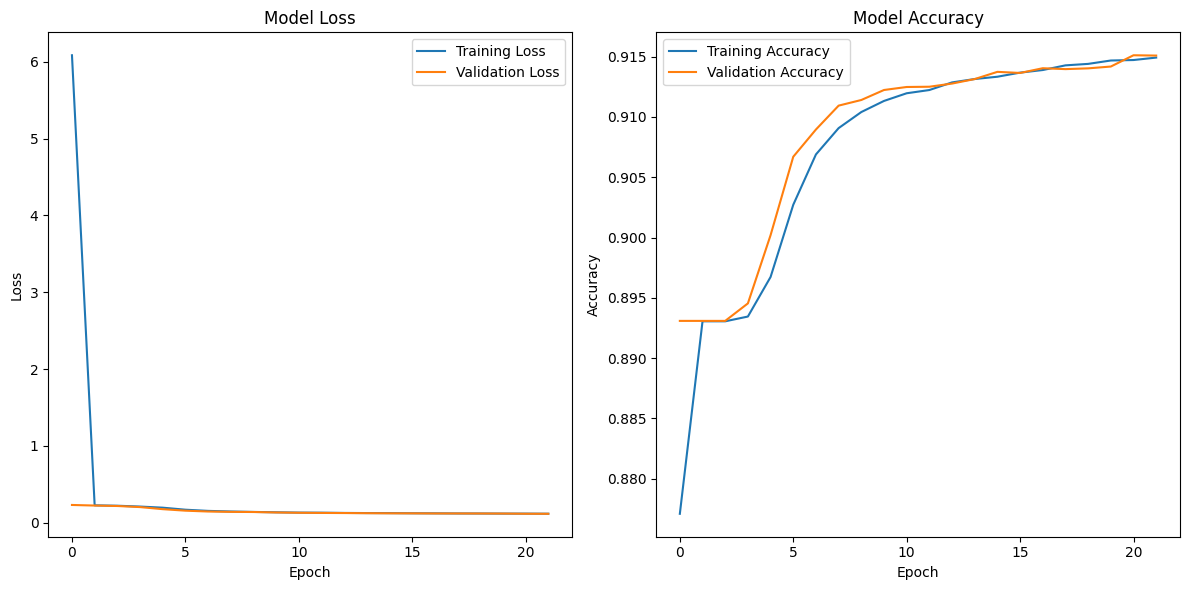

In [ ]:
# Plot training history to check for overfitting
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(model_history)

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

20/20 [==============================] - 4s 173ms/step - loss: 0.1175 - accuracy: 0.9151
Validation Loss: 0.11754649132490158, Validation Accuracy: 0.9150910973548889


In [ ]:
# Function to predict masks on a dataset
def predict_masks(model, dataset):
    predictions = []
    ground_truths = []

    for image, mask in dataset:
        prediction = model.predict(image)
        predictions.append(prediction)
        ground_truths.append(mask)

    return np.concatenate(predictions), np.concatenate(ground_truths)

# Predict masks on test set
test_predictions, test_ground_truths = predict_masks(model, test_dataset)

# Convert masks to binary (0 or 1) for evaluation metrics
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)
test_ground_truths_binary = np.where(test_ground_truths > 0.5, 1, 0)


In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(val_ground_truths_binary.flatten(), val_predictions_binary.flatten())
classification_rep = classification_report(val_ground_truths_binary.flatten(), val_predictions_binary.flatten(), target_names=['background', 'vessel'])

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Confusion Matrix:
[[9547983  133409]
 [ 245463  427833]]

Classification Report:
              precision    recall  f1-score   support

  background       0.97      0.99      0.98   9681392
      vessel       0.76      0.64      0.69    673296

    accuracy                           0.96  10354688
   macro avg       0.87      0.81      0.84  10354688
weighted avg       0.96      0.96      0.96  10354688



In [ ]:
# Predict masks on validation set
test_predictions, test_ground_truths = predict_masks(model, test_dataset)

# Convert masks to binary (0 or 1) for evaluation metrics
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)
test_ground_truths_binary = np.where(test_ground_truths > 0.5, 1, 0)

1/1 [==============================] - 0s 40ms/step


In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(test_ground_truths_binary.flatten(), test_predictions_binary.flatten())
classification_rep = classification_report(test_ground_truths_binary.flatten(), test_predictions_binary.flatten(), target_names=['background', 'vessel'])

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Confusion Matrix:
[[9523633  142859]
 [ 236452  451744]]

Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98   9666492
      vessel       0.76      0.66      0.70    688196

    accuracy                           0.96  10354688
   macro avg       0.87      0.82      0.84  10354688
weighted avg       0.96      0.96      0.96  10354688



In [ ]:
import matplotlib.pyplot as plt

def predict_and_visualize_masks(model, dataset, num_samples=5):
    predictions = []
    ground_truths = []
    images = []

    for image, mask in dataset.take(num_samples):
        prediction = model.predict(image)
        predictions.append(prediction)
        ground_truths.append(mask)
        images.append(image)

    predictions = np.concatenate(predictions)
    ground_truths = np.concatenate(ground_truths)
    images = np.concatenate(images)
    print(image)

    # Convert masks to binary (0 or 1) for visualization
    predictions_binary = np.where(predictions > 0.5, 1, 0)
    ground_truths_binary = np.where(ground_truths > 0.5, 1, 0)

    # Visualize the results
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(ground_truths_binary[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    #print(prediction)
    plt.show()

# Predict and visualize masks on test dataset
predict_and_visualize_masks(model, test_dataset, num_samples=5)


1/1 [==============================] - 0s 28ms/step
tf.Tensor(
[[[[0.01372549 0.00392157 0.01470588]
   [0.01078431 0.00490196 0.01666667]
   [0.01176471 0.00392157 0.01568628]
   ...
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]]

  [[0.01666667 0.01078431 0.0254902 ]
   [0.02941176 0.0127451  0.02058824]
   [0.0127451  0.00490196 0.01666667]
   ...
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]]

  [[0.92941177 0.9401961  0.9411765 ]
   [0.23137255 0.2127451  0.2       ]
   [0.01470588 0.00784314 0.01862745]
   ...
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]]

  ...

  [[0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   ...
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392157 0.01568628]
   [0.01176471 0.00392

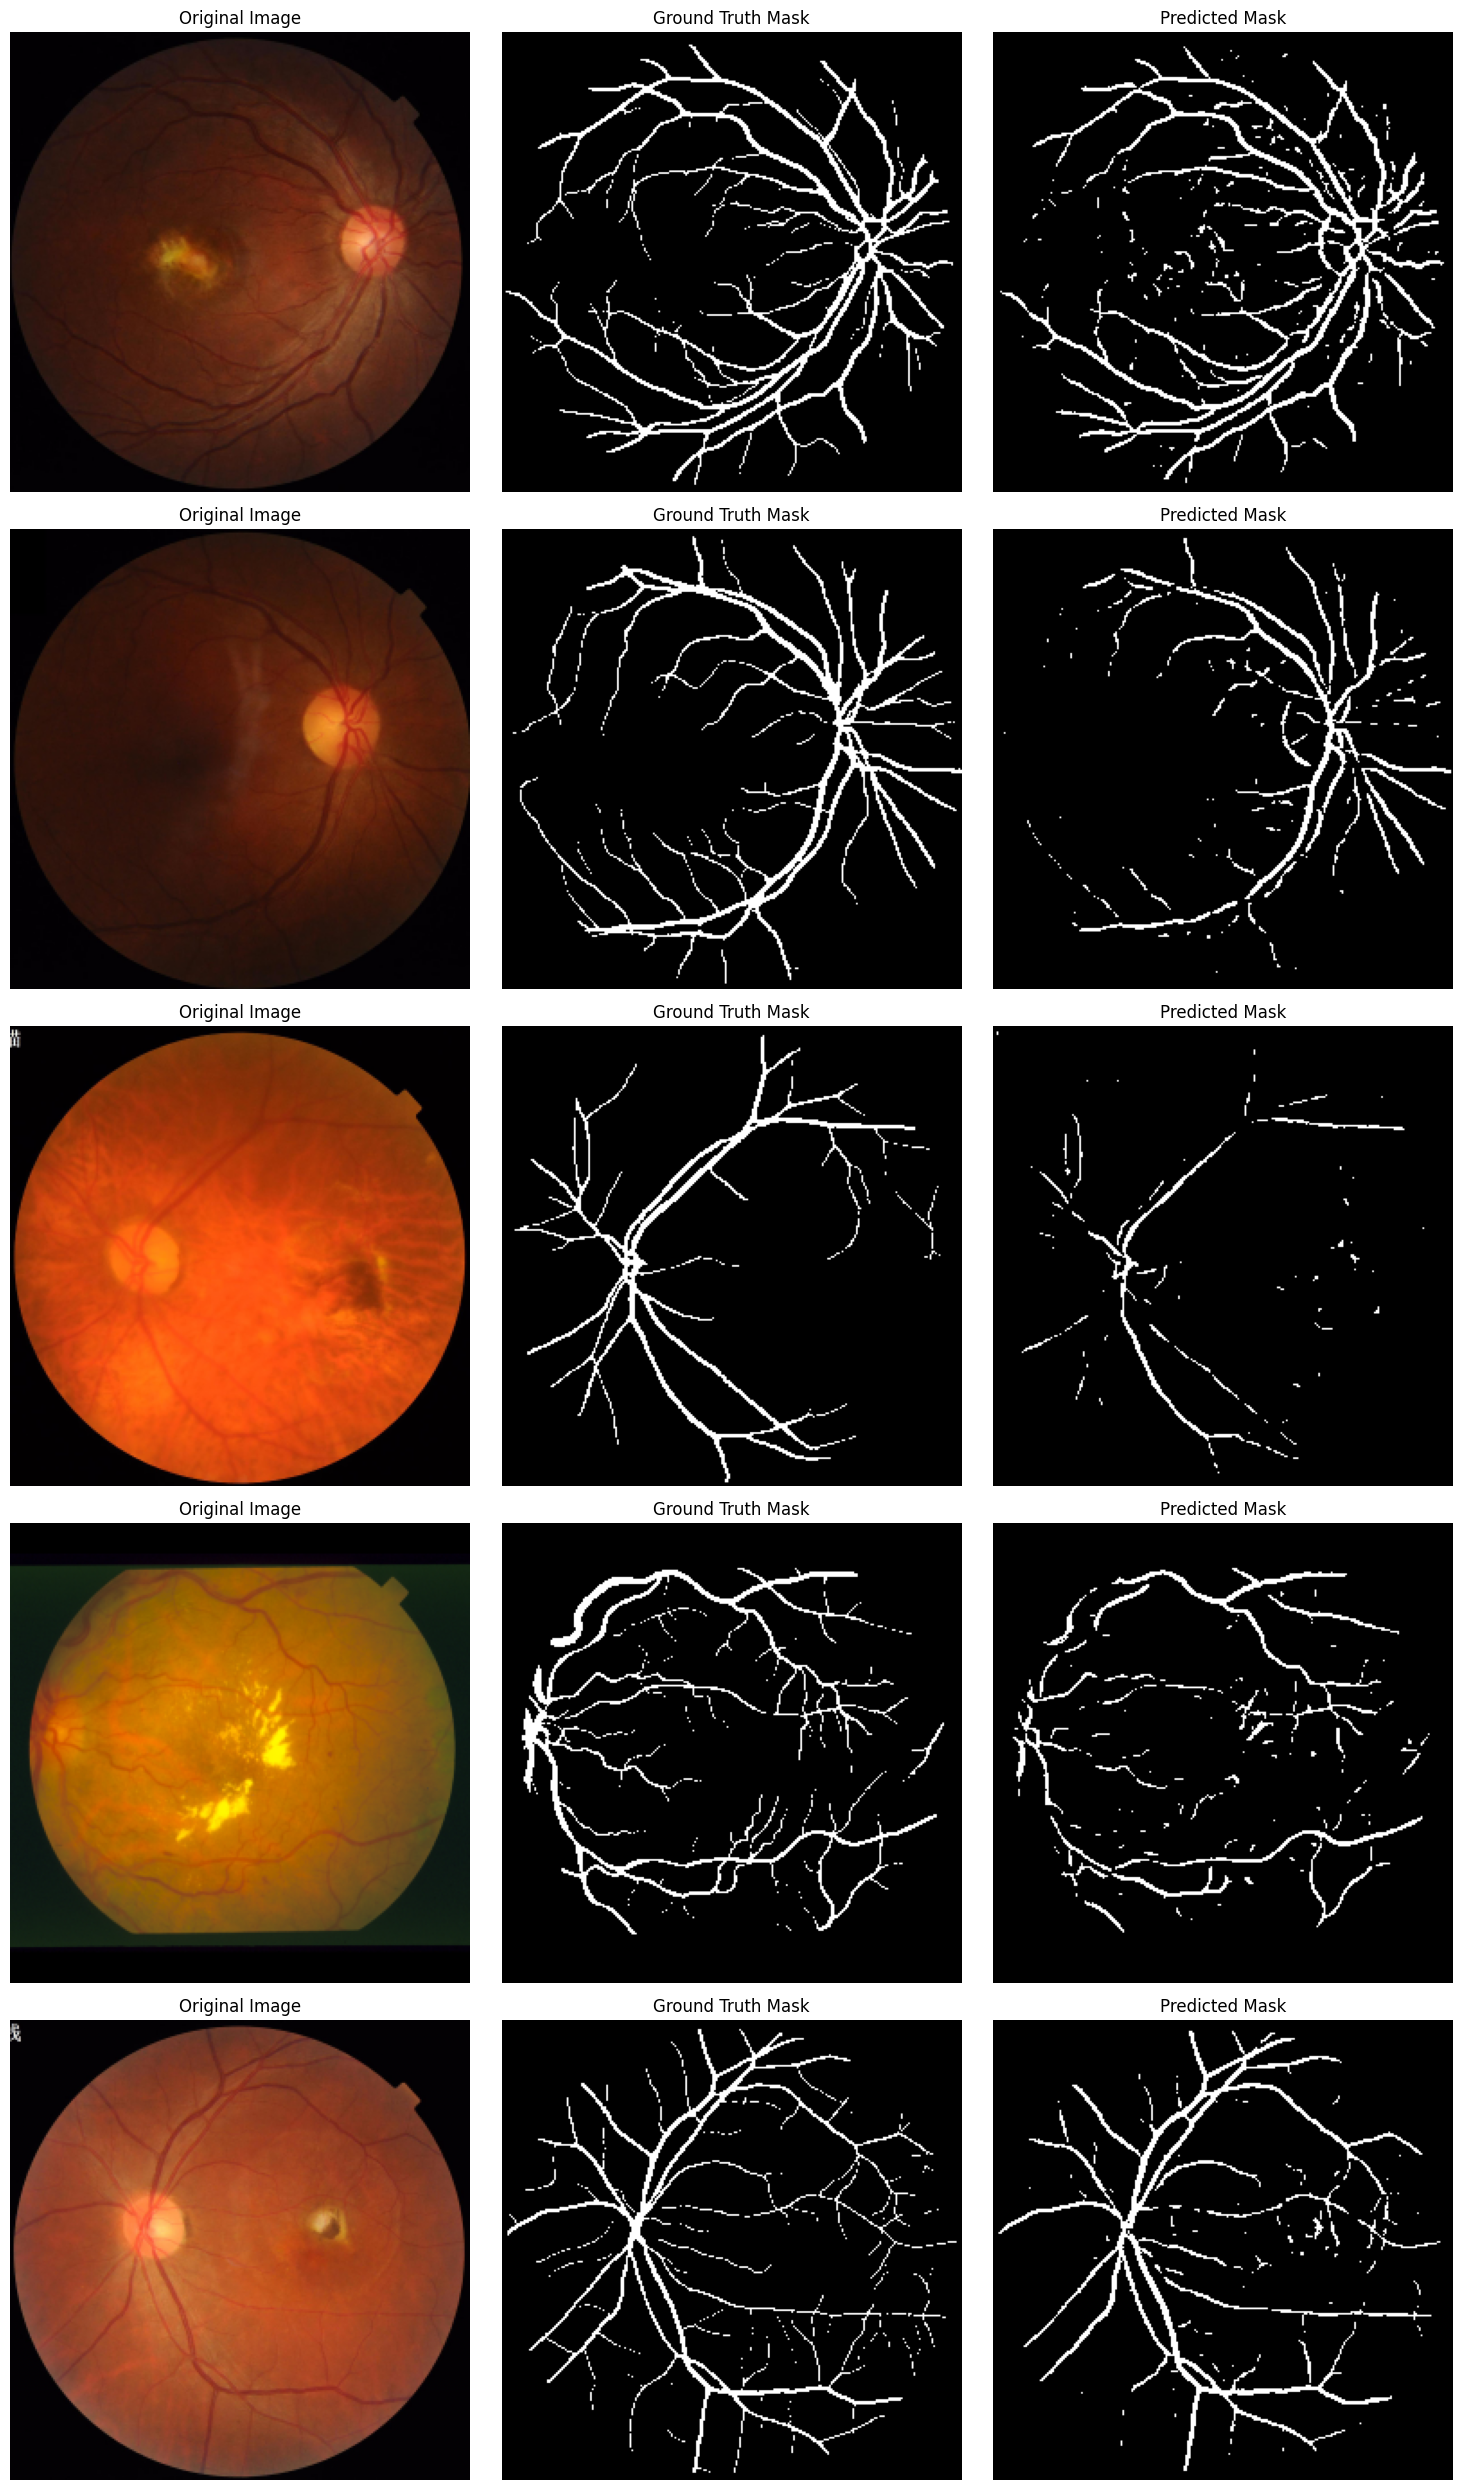

In [ ]:
import matplotlib.pyplot as plt

def predict_and_visualize_masks(model, dataset, num_samples=5):
    predictions = []
    ground_truths = []
    images = []

    for image, mask in dataset.take(num_samples):
        prediction = model.predict(image)
        predictions.append(prediction)
        ground_truths.append(mask)
        images.append(image)

    predictions = np.concatenate(predictions)
    ground_truths = np.concatenate(ground_truths)
    images = np.concatenate(images)
    print(image)

    # Convert masks to binary (0 or 1) for visualization
    predictions_binary = np.where(predictions > 0.5, 1, 0)
    ground_truths_binary = np.where(ground_truths > 0.5, 1, 0)

    # Visualize the results
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(ground_truths_binary[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    #print(prediction)
    plt.show()

# Predict and visualize masks on test dataset
predict_and_visualize_masks(model, test_dataset, num_samples=5)


In [ ]:
images

NameError: name 'images' is not defined

In [ ]:
from google.colab import drive
import tensorflow as tf


# Load the saved model from Google Drive
model_path = '/content/drive/MyDrive/Path_to_Save_Model/retinal_vessel_segmentation_model.h5'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")


Model loaded successfully.


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, img_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Example of preprocessing a single image
image_path = '/content/data.zip/retina/1003.png'  # image path
preprocessed_image = preprocess_image(image_path)
print("Image preprocessed successfully.")


Image preprocessed successfully.


1/1 [==============================] - 0s 33ms/step


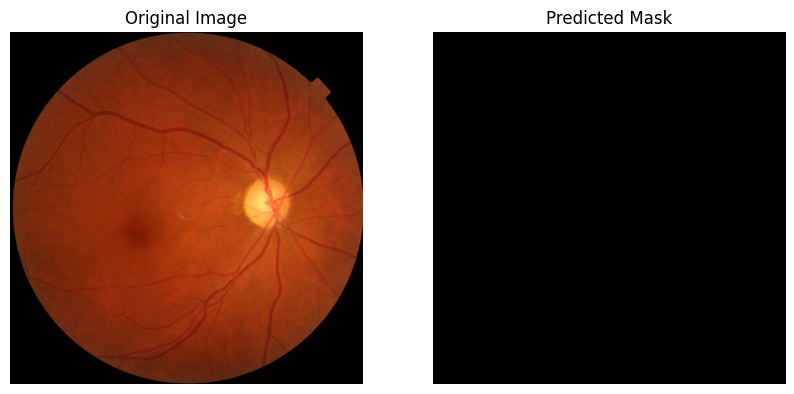

In [ ]:
# Make prediction
prediction = model.predict(preprocessed_image)

# Convert prediction to binary mask
predicted_mask = np.where(prediction > 0.5, 1, 0)

# Remove batch dimension for visualization
predicted_mask = np.squeeze(predicted_mask, axis=0)

# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
